### The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    7614 non-null   int64  
 1   bed             7614 non-null   float64
 2   bath            7614 non-null   float64
 3   acre_lot        7614 non-null   float64
 4   zip_code        7614 non-null   float64
 5   house_size      7614 non-null   float64
 6   prev_sold_date  7614 non-null   object 
 7   price           7614 non-null   float64
 8   prev_sold_year  7614 non-null   int64  
 9   zip_code_str    7614 non-null   int64  
 10  latitude        7614 non-null   float64
 11  longitude       7614 non-null   float64
 12  county          7614 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 773.4+ KB


#### Create an object to pass to the function that will normalize the data

In [4]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
#normalize_df = mean_and_std(params)
normalize_df = outliers_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
7609,7612,5.0,4.0,0.91,8848.0,1500.0,2017-11-07,485000.0,2017,8848,40.594266,-75.096659,2
7610,7613,4.0,3.0,2.17,8825.0,1500.0,2016-07-07,510000.0,2016,8825,40.514169,-75.027112,2
7611,7614,3.0,2.0,0.12,7012.0,1500.0,2021-10-20,499000.0,2021,7012,40.848398,-74.160266,7
7612,7615,3.0,3.0,0.13,7012.0,1500.0,2022-02-16,530000.0,2022,7012,40.848398,-74.160266,7
7613,7616,4.0,3.0,0.11,7640.0,1500.0,2016-06-16,720000.0,2016,7640,40.991681,-73.980202,7


#### Create a variable for the correlation of the normalized data

In [5]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.037860
bed               0.413451
bath              0.584847
house_size        0.337901
prev_sold_year    0.039367
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

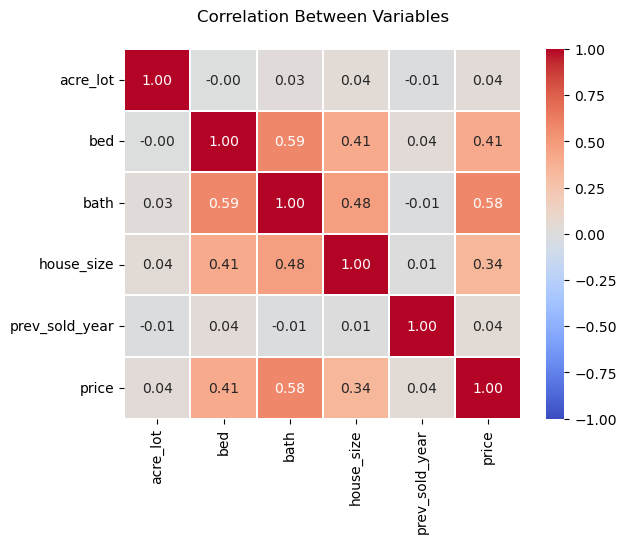

In [6]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [7]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [8]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Lasso Regression

In [12]:
myrange = []
for i in range(12,17):
    myrange.append(10**-i)
param_dict = {'alpha': myrange}
lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 1e-14}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
lasso_bp = dosomething("Lasso","Best Params", normalize_df, features, "price", lasso_gscv.best_params_)
results_dict_append(lasso_bp["results"])
lasso_bp_predict = lasso_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Best Params EVS = 0.389265833
Best Params MSE = 98,292,111,348.887619
Best Params MAE = 202,648.955983
Best Params R2 = 0.389235
Best Params Fit Time = 0.4264892578125


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [14]:
lasso_sfm = dosomething("Lasso","Select From Model", normalize_df, features, "price")
results_dict_append(lasso_sfm["results"])
lasso_sfm_predict = lasso_sfm["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Select From Model EVS = 0.389266234
Select From Model MSE = 98,292,046,996.143082
Select From Model MAE = 202,648.235990
Select From Model R2 = 0.389236
Select From Model Fit Time = 0.009395551681518555


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
lasso_sfs = dosomething("Lasso","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(lasso_sfs["results"])
lasso_sfs_predict = lasso_sfs["predictions"]

The selected features are: ['latitude', 'longitude', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.378652712
Sequential Feature Selector MSE = 100,001,498,876.605911
Sequential Feature Selector MAE = 204,878.518872
Sequential Feature Selector R2 = 0.378614
Sequential Feature Selector Fit Time = 0.006263589859008789


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [16]:
lasso_rfe = dosomething("Lasso","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(lasso_rfe["results"])
lasso_rfe_predict = lasso_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath']
Recursive Feature Elimination EVS = 0.385856612
Recursive Feature Elimination MSE = 98,836,621,981.127274
Recursive Feature Elimination MAE = 203,907.959239
Recursive Feature Elimination R2 = 0.385852
Recursive Feature Elimination Fit Time = 0.008767032623291015


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

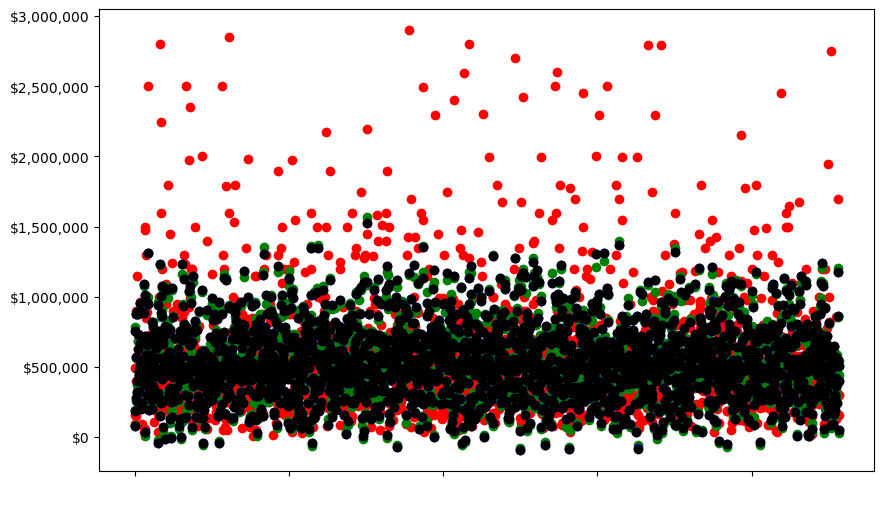

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="green")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="blue")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.389265833',
  '0.389266234',
  '0.378652712',
  '0.385856612'],
 'mae score': ['202,648.955983',
  '202,648.235990',
  '204,878.518872',
  '203,907.959239'],
 'mse score': ['98,292,111,348.887619',
  '98,292,046,996.143082',
  '100,001,498,876.605911',
  '98,836,621,981.127274'],
 'r2 score': ['0.389235', '0.389236', '0.378614', '0.385852'],
 'mean fit time': [0.4264892578125,
  0.009395551681518555,
  0.006263589859008789,
  0.008767032623291015]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.389265833,"202,648.955983","98,292,111,348.887619",0.389235,0.426489
Select From Model,0.389266234,"202,648.235990","98,292,046,996.143082",0.389236,0.009396
Sequential Feature Selector,0.378652712,"204,878.518872","100,001,498,876.605911",0.378614,0.006264
Recursive Feature Elimination,0.385856612,"203,907.959239","98,836,621,981.127274",0.385852,0.008767
